# Interactive Microscopy Control with ImJoy

Author: [Wei OUYANG](https://oeway.github.io/)

[ImJoy](https://imjoy.io) is a web framework for building interactive analysis tools. You can also use it to build easy-to-use and interactive data acquisition tool together with pycro-manager.

In this tutorial notebook, we will go through the steps for using ImJoy plugins with Pycro-Manager to control your microscope interactively. 

Here is a outline of this tutorial:
1. Preparation
1. Acquire an image and display it with matplotlib
1. Acquire and display images continuously with matplotlib
1. Build your first ImJoy plugin
1. Snap an image in the ImJoy plugin
1. Visualize the image with the itk-vtk-viewer plugin
1. Use a dedicated UI plugin with Pycro-Manager
1. Deploy your plugin to Github and share it
1. Additional Resources

## Preparation

You will be able to follow this tutorial in a local installation of Jupyter notebook. To use Pycro-Manager(which connects to Micro-Manager), you need to run the jupyter notebook server (typically with the `jupyter notebook` command) on the computer with Micro-Manager.

Importantly, Pycro-Manager exposes full access of your microscope to the python scripting interface, please be careful that some commands (e.g. moving the stage) may damage your hardware. Although this tutorial only involves camera control which is safe, we still recommend to disconnect your hardware and start Micro-Manager with the simulated demo devices for exploration, and only connect the hardware when you fully understand the scripts.


1. Install Pycro-Manager, ImJoy and [ImJoy Jupyter Extension](https://github.com/imjoy-team/imjoy-jupyter-extension) by run `pip install pycromanager imjoy imjoy-jupyter-extension`, then start or restart your Jupyter notebook server by using `jupyter notebook` command.
2. Create an empty notebook, or download and run [this one](https://github.com/micro-manager/pycro-manager/blob/master/docs/source/pycro_manager_imjoy_tutorial.ipynb). Make sure you see an ImJoy icon in the toolbar in opened notebooks.
3. If you don't have Micro-Manager installed, download the lastest version of [micro-manager 2.0](https://micro-manager.org/wiki/Micro-Manager_Nightly_Builds)
4. Run Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once)



In [ ]:
# if you don't see an ImJoy icon (blue) in the toolbar, run this cell
!pip install -U pycromanager imjoy imjoy-jupyter-extension

# And, restart your jupyter notebook after running the above command

To quickly verify whether you have everything ready, you should see something like `'MMCore version 10.1.0'` without error after running the following cell.

In [15]:
from imjoy import api

from pycromanager import Bridge

bridge = Bridge()
core = bridge.get_core()
core.get_version_info()

'MMCore version 10.1.0'

## Acquire an image and display it with matplotlib

By calling `core.snap_image()` we can control micromanager to acquire image and use `core.get_tagged_image()` to fetch the image data.

In a notebook, we can use matplotlib function `plt.imshow` to visualize the image.

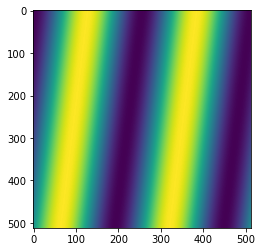

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


def snap_image():
    # acquire an image and display it
    core.snap_image()
    tagged_image = core.get_tagged_image()
    # get the pixels in numpy array and reshape it according to its height and width
    image_array = np.reshape(
        tagged_image.pix,
        newshape=[-1, tagged_image.tags["Height"], tagged_image.tags["Width"]],
    )
    # for display, we can scale the image into the range of 0~255
    image_array = (image_array / image_array.max() * 255).astype("uint8")
    # return the first channel if multiple exists
    return image_array[0, :, :]


plt.imshow(snap_image())

## Acquire and display images continuously
Since we are doing microscopy imaging with the microscope, it's important to be able to see a live stream, for example, for finding a field of view.

Jupyter notebook has little support for visualizing real-time data itself, but we can try to achieve live update by repeatitively clear the plot and draw again.

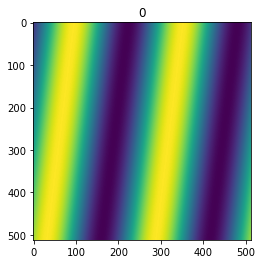

In [17]:
from IPython.display import clear_output

for i in range(5):
    clear_output(wait=True)
    plt.figure()
    plt.title(i)
    plt.imshow(snap_image())
    plt.show()

While we can see the live stream, it provides litte interactivity, for example, if we want to do contrast stretching, we will have to stop the stream and change the code. [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) is a Jupyter extension that designed for adding basic control elements (e.g. buttons and sliders) to control python code execution. There are also other similar extensions such as [mpl-interactions](https://mpl-interactions.readthedocs.io/en/latest/), and you can find more in [widgets](https://jupyter.org/widgets) (thanks to @ianhi). 

In addition to these existing options, we built [imjoy-jupyter-extension](https://github.com/imjoy-team/imjoy-jupyter-extension) that utilizes the ImJoy framework to introduce interactivity to Jupyter notebooks. It allows Python code to interact web UI directly without making dedicated Jupyter widgets in Python. It simplify the development of UI widgets, improve code reuse, and users can simply refer to an URL to extend the UI.

In the following section, we will show you how we can achieve better interactivity by building an ImJoy plugin.

## Build your first ImJoy plugin

Let's start by making a "hello world" plugin example with ImJoy.

An ImJoy plugin is a class defines at least two functions `setup` and `run`. In the `setup` function we put preparation or initialization code and the `run` function is an entrypoint when the user starts the plugin. As an example, we do nothing in the `setup` function and popup a hello world message in the `run` function.

Importantly, you need to export your plugin by running `api.export(ImJoyPlugin())` to register the plugin to the ImJoy core (running in the browser with the notebook page).

Now run the following cell.

If you see a popup message saying "hello world", congrats that you have build your first ImJoy plugin!

In [ ]:
from imjoy import api


class ImJoyPlugin:
    """Defines an ImJoy plugin"""

    async def setup(self):
        """for initialization"""
        pass

    async def run(self, ctx):
        """called when the user run this plugin"""

        # show a popup message
        await api.alert("hello world")


# register the plugin to the imjoy core
api.export(ImJoyPlugin())

Note: if the `async` and `await` keywords are new to you, you may want to learn about an imporant programing style called "asynchronous programming". It's basically a cheap way to achieve parallelizatin in a single thread, and Python3 provides [asyncio API](https://docs.python.org/3/library/asyncio-task.html) for it. With the async/await syntax, you can write async code as you usually do with your other synchronous code.

Don't worry if you don't fully understand asynchronous programming. For now you can treat it the same as regular python programming, but remember the following simplified rules:
1. it is recommended to add `await` before every ImJoy api call except `api.export`, e.g.: do `await api.alert("hello")`.
2. if you used `await` in a function, then you have to also add `async def` to define the function.

## Snap an image in the ImJoy plugin

Now let's define a function for acquire images with Pycro-Manager and call it `snap_image()`. Add this function into the plugin class and use it in the `run` function.

Run the fullowing cell, you should see a message if you acquired an image.

In [ ]:
import numpy as np
from imjoy import api

from pycromanager import Bridge


class MyMicroscope:
    """Defines a Microscope plugin"""

    async def setup(self):
        """initialize the pycro-manager bridge"""
        bridge = Bridge()
        self._core = bridge.get_core()

    def snap_image(self):
        """snape an image with the pycro-manager bridge and return it as a numpy array"""
        self._core.snap_image()
        tagged_image = self._core.get_tagged_image()
        # get the pixels in numpy array and reshape it according to its height and width
        image_array = np.reshape(
            tagged_image.pix,
            newshape=[-1, tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
        # for display, we can scale the image into the range of 0~255
        image_array = (image_array / image_array.max() * 255).astype("uint8")
        return image_array

    async def run(self, ctx):
        """acquire one image and notify the user"""
        img = self.snap_image()
        # show a popup message
        await api.alert(
            "Acquired an image (size={}) with Pycro-Manager".format(img.shape)
        )


# register the plugin to the imjoy core
api.export(MyMicroscope())

## Visualize the image with the itk-vtk-viewer plugin

To show the images, we can use another ImJoy plugin called itk-vtk-viewer which provide rich featuers including color map, contrast stretching, scaling. It can be used directly via this link: https://oeway.github.io/itk-vtk-viewer/ as standalone web app, but also available as an ImJoy plugin.

To use it, you can run `viewer = await api.showDialog(src="https://oeway.github.io/itk-vtk-viewer/")` to create a viewer. The returned `viewer` object contains a set of API functions exported by the itk-vtk-viewer plugin, and we will call `viewer.imshow()` for displaying images where `imshow` is one of the API functions.

Note that we need to add `await` before `api.showDialog`, but also all the returned API functions including `imshow()`.

In the following plugin, we call `snape_image` and `viewer.imshow` in a for loop inside the `run` function, to continuously display the image.


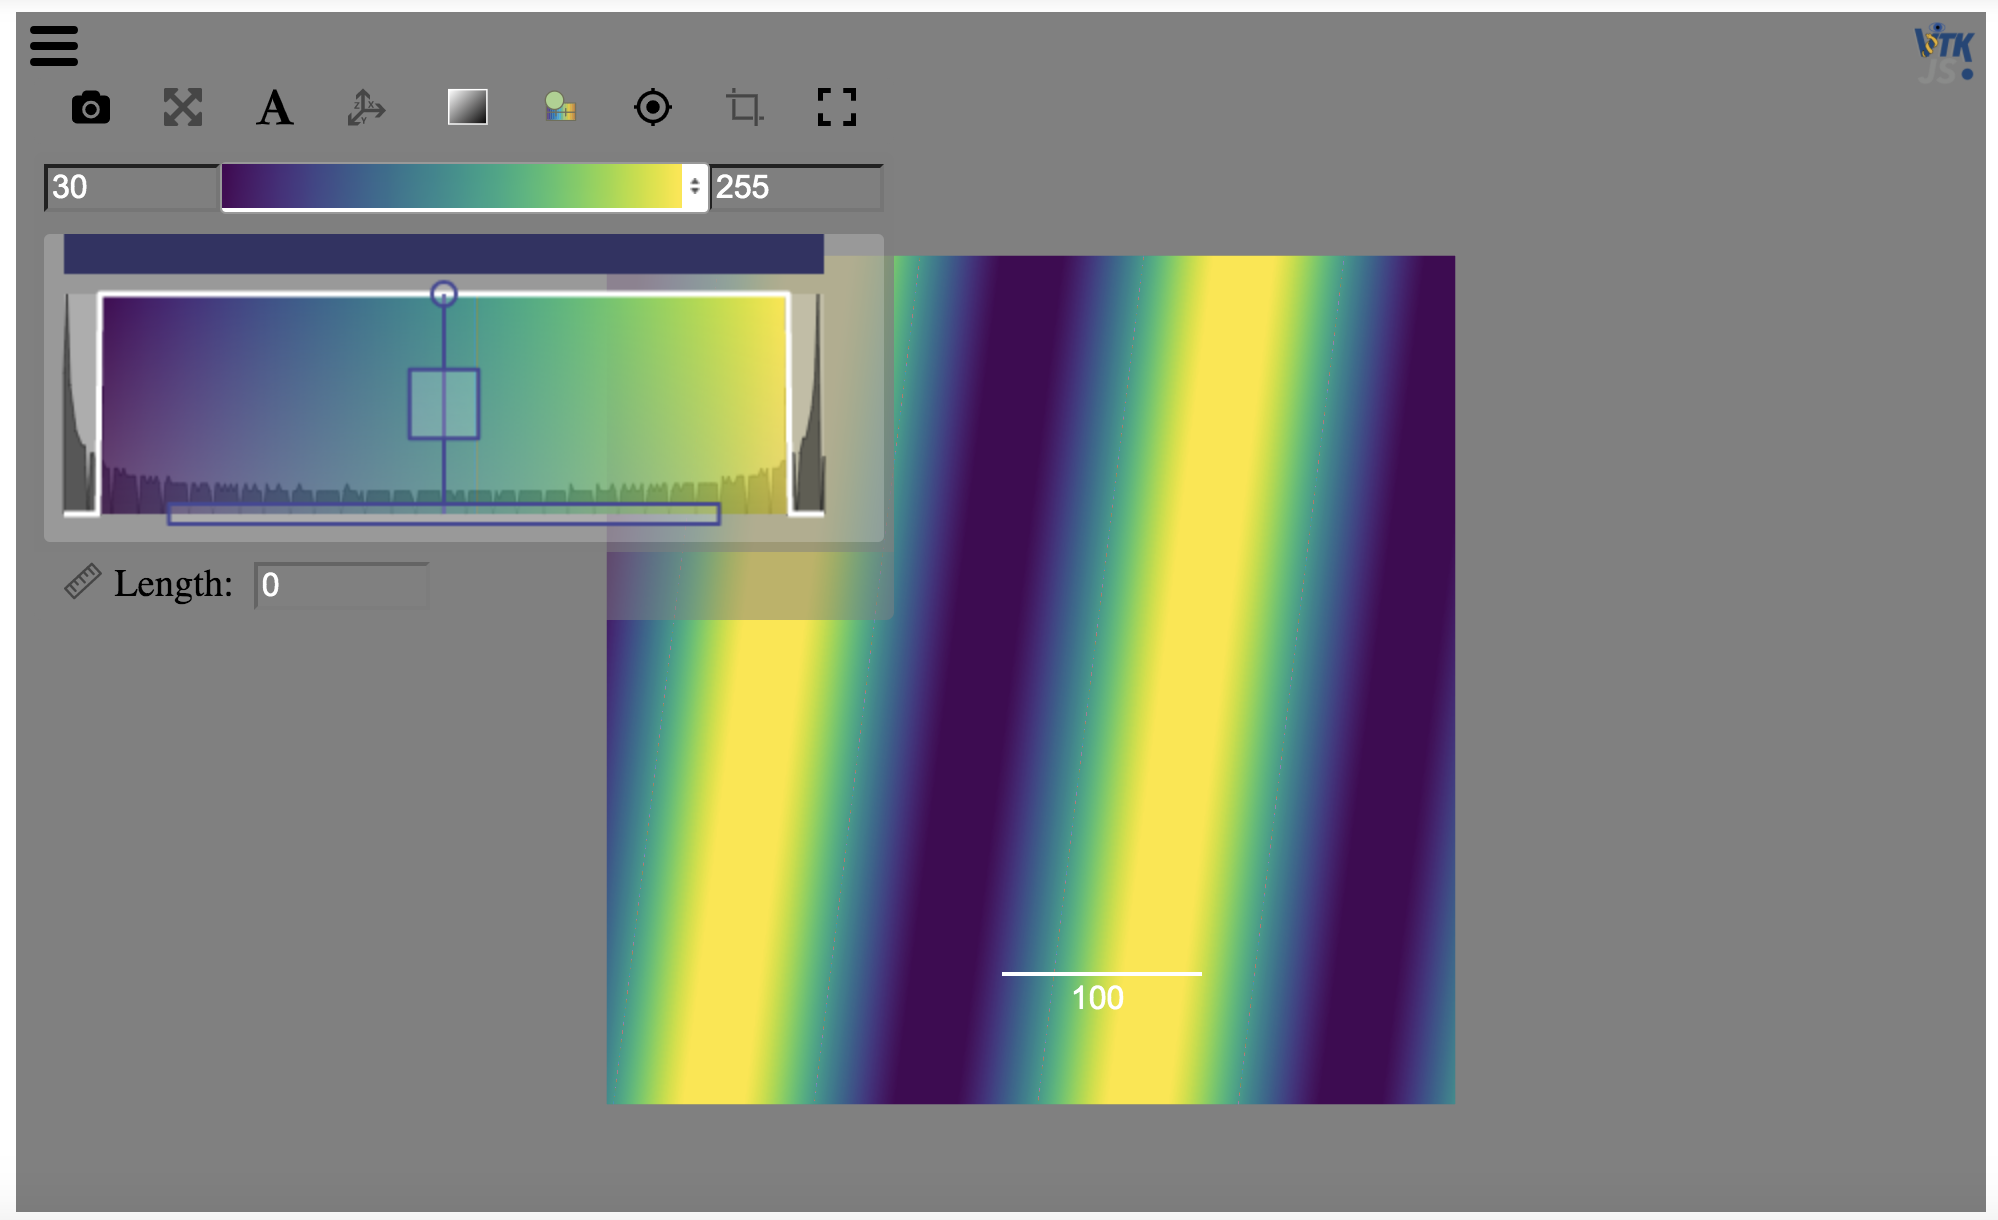

In [20]:
import numpy as np
from imjoy import api

from pycromanager import Bridge


class MyMicroscope:
    """Defines a Microscope plugin"""

    async def setup(self):
        """initialize the pycro-manager bridge"""
        bridge = Bridge()
        self._core = bridge.get_core()

    def snap_image(self):
        """snape an image with the pycro-manager bridge and return it as a numpy array"""
        self._core.snap_image()
        image_array = self._core.get_image().reshape(512, 512)
        # for display, we can scale the image into the range of 0~255
        image_array = (image_array / image_array.max() * 255).astype("uint8")
        return image_array

    async def run(self, ctx):
        """acquire 100 images and show them with itk-vtk-viewer"""
        viewer = await api.createWindow(src="https://oeway.github.io/itk-vtk-viewer/")
        api.showMessage("Acquiring 100 images")
        for i in range(100):
            img = self.snap_image()
            await viewer.imshow(img)
        api.showMessage("Done.")


api.export(MyMicroscope())

The itk-vtk-viewer plugin provides rich features for inspecting the displayed image, but it does not provide features to control the microscope.

## Use a dedicated UI plugin with Pycro-Manager

ImJoy allows developers build custom plugins and can be easily used later in another plugin. For example, we can add buttons to snap image, provide options to change exposure in a custom UI plugin.

For working with Pycro-Manager, we made a dedicated UI plugin called "PycroCam" which can be referred via https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd. If you are interested in how to make such a plugin, cick the link and you will see the plugin source code in HTML, Javascript and CSS.

For this tutorial, we will focuse on using such a plugin with Pycro-Manager and it's as easy as calling `pycrocam = await api.createWindow(src="https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd", data={...})`.

Slightly different from the above example where we create a window via `api.createWindow` and we use the returned `viewer` object to access API functions such as `imshow`. In this example, we will directly pass a set of Micro-Manager core api functions to the `PycroCam` plugin so we can directly control the microscope within the plugin.

In the following `run` function, you will see that we first construct a dictionary (named `mmcore_api`) with a set of functions required by the plugin including `snapImage`, `getImage` and `setExposure`. Then we pass the dictionary into `api.createWindow()` as a keyword `data`, specifically, `data={'mmcore': mmcore_api}`. 


Run the following cell, and you will see the PycroCam UI with snap and live buttons, set exposure and binning. In addition you can click the "Device Properties" which will popup a device property browser. Just like the one in Micro-Manager itself, you can change almost any property with that.

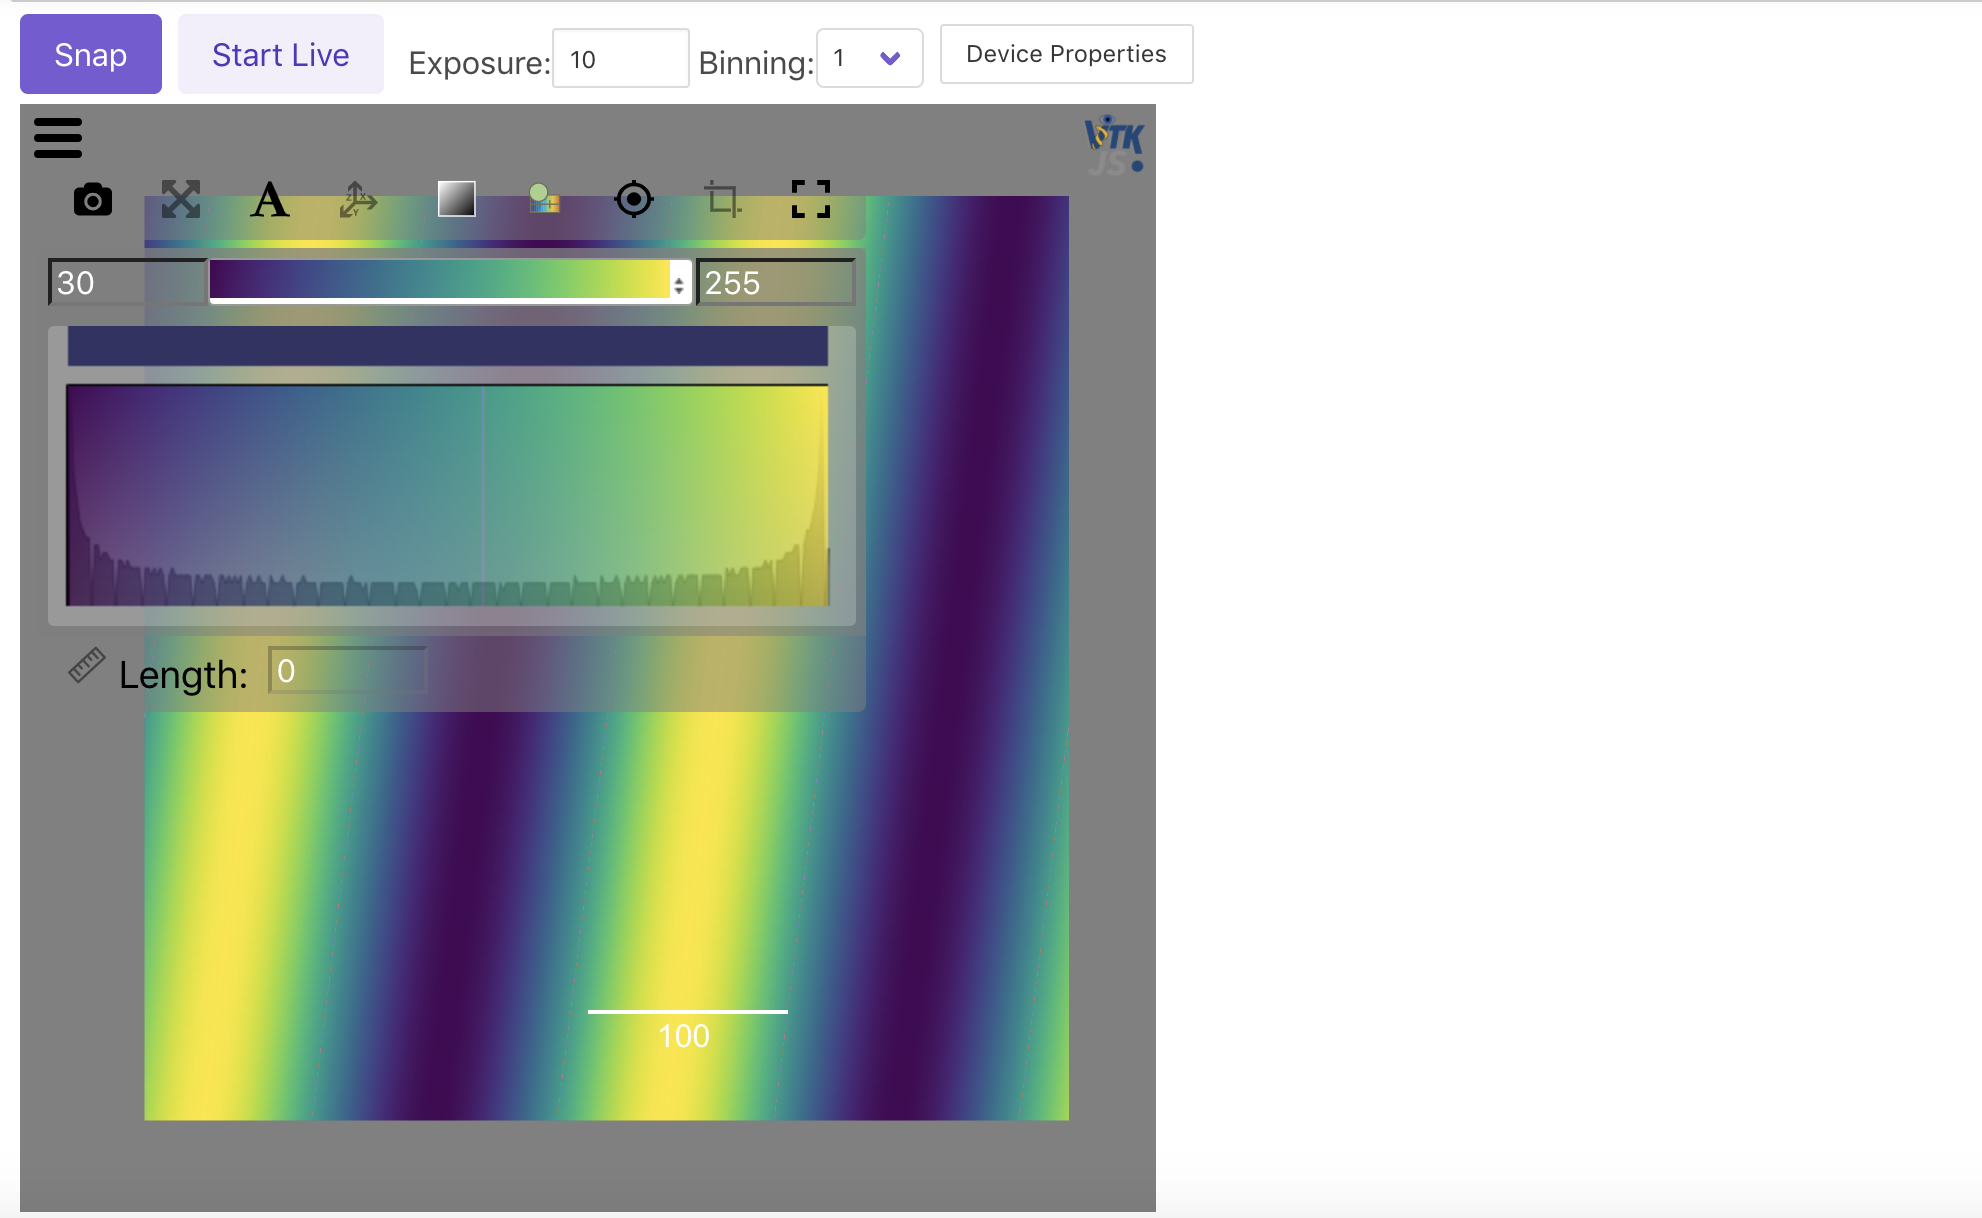

In [21]:
import time

import numpy as np
from imjoy import api

from pycromanager import Bridge


class MyMicroscope:
    async def setup(self):
        bridge = Bridge()
        self._core = bridge.get_core()
        exposure = self._core.get_exposure()
        api.showMessage("MMcore loaded, exposure: " + str(exposure))

    def snap_image(self):
        if self._core.is_sequence_running():
            self._core.stop_sequence_acquisition()
        self._core.snap_image()
        return self.get_image()

    def get_image(self):
        # we can also check remaining with getRemainingImageCount()
        tagged_image = self._core.get_tagged_image()
        image_array = np.reshape(
            tagged_image.pix,
            newshape=[-1, tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
        image_array = (image_array / image_array.max() * 255).astype("uint8")
        return image_array

    def get_device_properties(self):
        core = self._core
        devices = core.get_loaded_devices()
        devices = [devices.get(i) for i in range(devices.size())]
        device_items = []
        for device in devices:
            names = core.get_device_property_names(device)
            props = [names.get(i) for i in range(names.size())]
            property_items = []
            for prop in props:
                value = core.get_property(device, prop)
                is_read_only = core.is_property_read_only(device, prop)
                if core.has_property_limits(device, prop):
                    lower = core.get_property_lower_limit(device, prop)
                    upper = core.get_property_upper_limit(device, prop)
                    allowed = {
                        "type": "range",
                        "min": lower,
                        "max": upper,
                        "readOnly": is_read_only,
                    }
                else:
                    allowed = core.get_allowed_property_values(device, prop)
                    allowed = {
                        "type": "enum",
                        "options": [allowed.get(i) for i in range(allowed.size())],
                        "readOnly": is_read_only,
                    }
                property_items.append(
                    {"device": device, "name": prop, "value": value, "allowed": allowed}
                )
                # print('===>', device, prop, value, allowed)
            if len(property_items) > 0:
                device_items.append(
                    {
                        "name": device,
                        "value": "{} properties".format(len(props)),
                        "items": property_items,
                    }
                )
        return device_items

    async def run(self, ctx):
        mmcore_api = {
            "_rintf": True,
            "snapImage": self.snap_image,
            "getImage": self.get_image,
            "getDeviceProperties": self.get_device_properties,
            "getCameraDevice": self._core.get_camera_device,
            "setCameraDevice": self._core.set_camera_device,
            "startContinuousSequenceAcquisition": self._core.start_continuous_sequence_acquisition,
            "stopSequenceAcquisition": self._core.stop_sequence_acquisition,
            "setExposure": self._core.set_exposure,
            "getExposure": self._core.get_exposure,
            "setProperty": self._core.set_property,
            "getProperty": self._core.get_property,
        }
        viewer = await api.createWindow(
            src="https://gist.github.com/oeway/f59c1d1c49c94a831e5e21ba4c6111dd",
            data={"mmcore": mmcore_api},
        )


api.export(MyMicroscope())

## Deploy your plugin to Github and share it

Jupyter notebook serves as a good tool for learning, developing and debuging ImJoy plugins with PycroManager. Once the development is done, for users who just want to use the tool, it's not helpful to show all the code and documentation with a notebook. ImJoy plugins are disgned to be easily deployed and shared with others.

We can basically copy and paste the above cell into a text file, add additional fields such as plugin name and dependent libraries, save and upload to Github or Gist, then we can obtain a URL and share with others.

Here are the steps:

1. Create an empty text file named `PycroManagerControl.imjoy.html`(optionally, replace `PycroManagerControl` into any other name you like), then open it using your favorate code or text editor.

2. Copy and paste the following config block with into the file:
```html
<config lang="json">
{
  "name": "PycroManagerControl",
  "type": "native-python",
  "version": "0.1.0",
  "description": "Microscope control with PycroManager",
  "tags": [],
  "ui": "",
  "cover": "",
  "inputs": null,
  "outputs": null,
  "flags": [],
  "icon": "extension",
  "api_version": "0.1.8",
  "env": "",
  "permissions": [],
  "requirements": ["pycromanager", "numpy"],
  "dependencies": []
}
</config>
```
This config block in JSON format provides meta information for the plugin. We can leave most fields empty but it's important to set the `name`, `type` (must be `native-python`), `description`, and `requirements`. The `requirements` is basically `pip` install commands (the same as a `requirements.txt` file).

3. Add an empty script block after the `<config>` block, and fill in by copy and paste the Python code of the above cell:

```
<script lang="python">

# copy and paste your plugin code here

</script>
```

4. Now save the file and make sure the file name ends with extension `.imjoy.html`.

5. Optionally, we an test the plugin in ImJoy. Go to https://imjoy.io/#/app to start ImJoy, click the 🚀 located in the upper-right corner, click "Add Jupyter Engine", in the popup dialog, copy and paste your jupyter server url (must contains token, e.g.: `http://localhost:8888/?token=caac2d7f2e8e0...ad871fe`) to the dialog and click "CONNECT TO JUPYTER". Drag and drop your ImJoy plugin file into the window and you will see the plugin loaded into a code editor. Now click the play button to run the plugin. You should be able to see the same window as you see in the Jupyter notebook. If necessary you can also modify the code and run again.

6. Once you are satisfied with your plugin, upload it to project repo on Github, or [Gist](https://gist.github.com/) which is ideal for saving ImJoy plugin files. You will get a URL after you save or upload the plugin file. For example: https://gist.github.com/oeway/f2564258a5a72fa8819e30fda34f030d

7. To share the plugin with others, you can directly send the source code url generated in step 6, or simply construct a one click plugin URL by adding your plugin URL after `https://imjoy.io/#/app?plugin=`. For example: `https://imjoy.io/#/app?plugin=https://gist.github.com/oeway/f2564258a5a72fa8819e30fda34f030d`. Note: any one get the link can only connect to their own Jupyter notebook server and Micro-Manager.


## Question and additional resources

If you have any question, feel free to reach out on image.sc: https://forum.image.sc/tag/imjoy

For more detailed information about ImJoy and plugin development with ImJoy, please consult https://imjoy.io/docs/.


We also made a similar tutorial for the Python binding of Micro-Manager (named [pymmcore](https://pypi.org/project/pymmcore/)), see [here](https://gist.github.com/oeway/d40d68bda5f8401f88a56c67bafd1791). This is useful if you don't need the java interface or you want to run multiple instances of Micro-Manager.